In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS, SAMPLING_FREQUENCY
from loren_frank_data_processing import make_epochs_dataframe

epoch_info = make_epochs_dataframe(ANIMALS)

In [140]:
import numpy as np
import pandas as pd
from scipy.ndimage.measurements import label

from loren_frank_data_processing.core import get_data_structure
from loren_frank_data_processing.tetrodes import get_trial_time
from loren_frank_data_processing.position import get_position_dataframe, get_linear_position_structure



def get_interpolated_position_dataframe(epoch_key, animals,
                                        time_function=get_trial_time,
                                        max_distance_from_well=10):
    '''Gives the interpolated position of animal for a given epoch.

    Defaults to interpolating the position to the LFP time. Can use the
    `time_function` to specify different time to interpolate to.

    Parameters
    ----------
    epoch_key : tuple
    animals : dict of named-tuples
        Dictionary containing information about the directory for each
        animal. The key is the animal_short_name.
    time_function : function, optional
        Function that take an epoch key (animal_short_name, day, epoch) that
        defines the time the multiunits are relative to. Defaults to using
        the time the LFPs are sampled at.

    Returns
    -------
    interpolated_position : pandas.DataFrame

    '''
    time = time_function(epoch_key, animals)
    position = (pd.concat(
        [get_linear_position_structure(epoch_key, animals),
         get_position_dataframe(epoch_key, animals)], axis=1)
         .drop('trajectory_category_ind', axis=1, errors='ignore')
    )
    old_dt = (position.index[1] - position.index[0]).total_seconds()

    well_locations = get_well_locations(epoch_key, animals)
    xy = np.stack((position.x_position, position.y_position), axis=1)
    segments_df, labeled_segments = segment_path(
        position.index, xy, well_locations,
        max_distance_from_well=max_distance_from_well)
    segments_df = score_inbound_outbound(segments_df).loc[
        :, ['from_well', 'to_well', 'task', 'is_correct']]

    segments_df = pd.merge(
        labeled_segments, segments_df, right_index=True,
        left_on='labeled_segments', how='outer')
    position = pd.concat((position, segments_df), axis=1)

    categorical_columns = ['labeled_segments', 'from_well', 'to_well', 'task',
                           'is_correct']
    continuous_columns = ['head_direction', 'speed', 'linear_distance',
                          'x_position', 'y_position']
    position_categorical = (position
                            .drop(continuous_columns, axis=1)
                            .reindex(index=time, method='pad'))
    position_continuous = position.drop(categorical_columns, axis=1)
    new_index = pd.Index(np.unique(np.concatenate(
        (position_continuous.index, time))), name='time')
    interpolated_position = (position_continuous
                             .reindex(index=new_index)
                             .interpolate(method='values')
                             .reindex(index=time))
    interpolated_position.loc[
        interpolated_position.linear_distance < 0, 'linear_distance'] = 0
    interpolated_position.loc[interpolated_position.speed < 0, 'speed'] = 0
    limit = np.ceil(old_dt / (time[1] - time[0]).total_seconds()).astype(int)
    return (pd.concat([position_categorical, interpolated_position], axis=1)
            .fillna(method='backfill', limit=limit))


def paired_distances(x, y):
    '''Euclidean distance between x and y at each time point.

    Parameters
    ----------
    x,y : ndarray, shape (n_time, n_space)

    Returns
    -------
    distance : ndarray, shape (n_time,)

    '''
    x, y = np.array(x), np.array(y)
    x = np.atleast_2d(x).T if x.ndim < 2 else x
    y = np.atleast_2d(y).T if y.ndim < 2 else y
    return np.linalg.norm(x - y, axis=1)


def enter_exit_target(position, target, max_distance=1):
    '''Marks when a position has reached a target ("enter")
    and when it has left a target ("exit").

    The position is considered to have reached a target when it is less than
    the `max_distance` from the target.

    Enter and exit times are marked as follows:
     1: entered the target radius
     0: neither
    -1: exited the target radius

    Works for 1D position and 2D position.

    Parameters
    ----------
    position : ndarray, shape (n_time, n_space)
    target : ndarray, shape (1, n_space)
    max_distance : float, optional
        How close the position is to the target to be considered at the target.

    Returns
    -------
    enter_exit : ndarray, shape (n_time,)
    at_target : ndarray, shape (n_time,)

    '''
    distance_from_target = paired_distances(position, target)
    at_target = distance_from_target < max_distance
    enter_exit = np.r_[0, np.diff(at_target.astype(float))]
    return enter_exit, at_target


def shift_well_enters(enter_exit):
    '''Shifts the enter times back one time point.'''
    shifted_enter_exit = enter_exit.copy()
    old_ind = np.where(enter_exit > 0)[0]  # positive entries are well-entries
    new_ind = old_ind - 1
    shifted_enter_exit[new_ind] = enter_exit[old_ind]
    shifted_enter_exit[old_ind] = 0
    return shifted_enter_exit


def segment_path(time, position, well_locations, max_distance_from_well=15):
    '''Label traversals between each well location.

    Parameters
    ----------
    time : ndarray, shape (n_time,)
    position : ndarray, shape (n_time, n_space)
    well_locations : array_like, shape (n_wells, n_space)
    max_distance_from_well : float, optional
        The animal is considered at a well location if its position is closer
        than this value.

    Returns
    -------
    segments_df : pandas DataFrame, shape (n_segments, 6)
    labeled_segments : pandas DataFrame, shape (n_time,)

    '''
    n_wells = len(well_locations)
    well_enter_exit, at_target = np.stack(
        [enter_exit_target(position, np.atleast_2d(well),
                           max_distance_from_well)
         for well in well_locations], axis=1)

    well_labels = np.arange(n_wells) + 1
    well_enter_exit = np.sum(well_enter_exit.T * well_labels, axis=1)
    shifted_well_enter_exit = shift_well_enters(well_enter_exit)
    is_segment = ~(np.sum(at_target, axis=0) > 0)
    labeled_segments, n_segment_labels = label(is_segment)
    segment_labels = np.arange(n_segment_labels) + 1

    start_time, end_time, duration = [], [], []
    distance_traveled, from_well, to_well = [], [], []

    for segment_label in segment_labels:
        is_seg = np.in1d(labeled_segments, segment_label)
        segment_time = time[is_seg]
        start_time.append(segment_time.min())
        end_time.append(segment_time.max())
        duration.append(segment_time.max() - segment_time.min())
        try:
            start, _, end = np.unique(shifted_well_enter_exit[is_seg])
        except ValueError:
            start, end = np.nan, np.nan

        from_well.append(np.abs(start))
        to_well.append(np.abs(end))
        p = position[is_seg]
        distance_traveled.append(np.sum(paired_distances(p[1:], p[:-1])))

    data = [('start_time', start_time), ('end_time', end_time),
            ('duration', duration), ('from_well', from_well),
            ('to_well', to_well),
            ('distance_traveled', distance_traveled)]
    index = pd.Index(segment_labels, name='segment')
    return (pd.DataFrame.from_items(data).set_index(index),
            pd.DataFrame(dict(labeled_segments=labeled_segments), index=time))


def find_last_non_center_well(segments_df, segment_ind):
    last_wells = segments_df.iloc[:segment_ind - 1].to_well
    try:
        return last_wells[last_wells != 'center'].iloc[-1]
    except IndexError:
        # There are no non-center wells
        return segments_df.iloc[segment_ind].to_well


def get_correct_inbound_outbound(segments_df):
    n_segments = segments_df.shape[0]
    task = np.empty((n_segments,), dtype=object)
    is_correct = np.empty((n_segments,), dtype=bool)

    for segment_ind in np.arange(n_segments):
        if segments_df.iloc[segment_ind].from_well == 'center':
            task[segment_ind] = 'outbound'
            is_correct[segment_ind] = (
                segments_df.iloc[segment_ind].to_well ==
                find_last_non_center_well(segments_df, segment_ind))
        else:
            task[segment_ind] = 'inbound'
            is_correct[segment_ind] = (
                segments_df.iloc[segment_ind].to_well == 'center')

    segments_df['task'] = task
    segments_df['is_correct'] = is_correct

    return segments_df


def score_inbound_outbound(segments_df, min_distance_traveled=100):
    '''In the alternating arm task, determines whether the trial should be
    inbound (running to the center arm) or outbound (running to the opposite
    outer arm as before) and if the trial was performed correctly.

    Parameters
    ----------
    segments_df : pandas DataFrame
        Output of `segment_path` function.
    min_distance_traveled : float, optional
        Minimum path length (in cm) while outside of the well radius for
        a segment to be considered as a trial.

    Returns
    -------
    segments_df : pandas DataFrame
        Same as the input dataframe but with the wells labeled
        (left, right, center) and columns for `task` (inbound/outbound) and
        `is_correct` (True/False).
    '''
    segments_df = (segments_df.copy()
                   .loc[segments_df.distance_traveled > min_distance_traveled]
                   .dropna())
    WELL_NAMES = {
        1: 'center',
        2: 'left',
        3: 'right'
    }
    segments_df = segments_df.assign(
        to_well=lambda df: df.to_well.map(WELL_NAMES),
        from_well=lambda df: df.from_well.map(WELL_NAMES))
    return get_correct_inbound_outbound(segments_df)


def get_well_locations(epoch_key, animals):
    '''Retrieves the 2D coordinates for each well.
    '''
    animal, day, epoch = epoch_key
    task_file = get_data_structure(animals[animal], day, 'task', 'task')
    linearcoord = task_file[epoch - 1]['linearcoord'][0, 0].squeeze()
    well_locations = []
    for arm in linearcoord:
        well_locations.append(arm[0, :, 0])
        well_locations.append(arm[-1, :, 0])
    well_locations = np.stack(well_locations)
    _, ind = np.unique(well_locations, axis=0, return_index=True)
    return well_locations[np.sort(ind), :]


In [81]:
epoch_info.xs('fra').dropna()

environment type  exposure
day epoch                           
2   2          TrackB  run       1.0
    4          TrackB  run       2.0
    6          TrackA  run       1.0
3   2          TrackB  run       3.0
    4          TrackB  run       4.0
    6          TrackA  run       2.0
4   2          TrackB  run       5.0
    4          TrackB  run       6.0
    6          TrackA  run       3.0
5   2          TrackB  run       7.0
    4          TrackB  run       8.0
    6          TrackA  run       4.0
6   2          TrackB  run       9.0
    4          TrackB  run      10.0
    6          TrackA  run       5.0
7   2          TrackB  run      11.0
    4          TrackB  run      12.0
    6          TrackA  run       6.0
8   2          TrackB  run      13.0
    4          TrackB  run      14.0
    6          TrackA  run       7.0
9   2          TrackB  run      15.0
    4          TrackB  run      16.0
    6          TrackA  run       8.0
10  2          TrackB  run      17.0
    4          TrackB  run      18.0
    6          TrackA  run       9.0
11  2          TrackB  run      19.0
    4          TrackB  run      20.0
    6          TrackA  run      10.0
12  2          TrackB  run      21.0
    4          TrackB  run      22.0
    6          TrackA  run      11.0

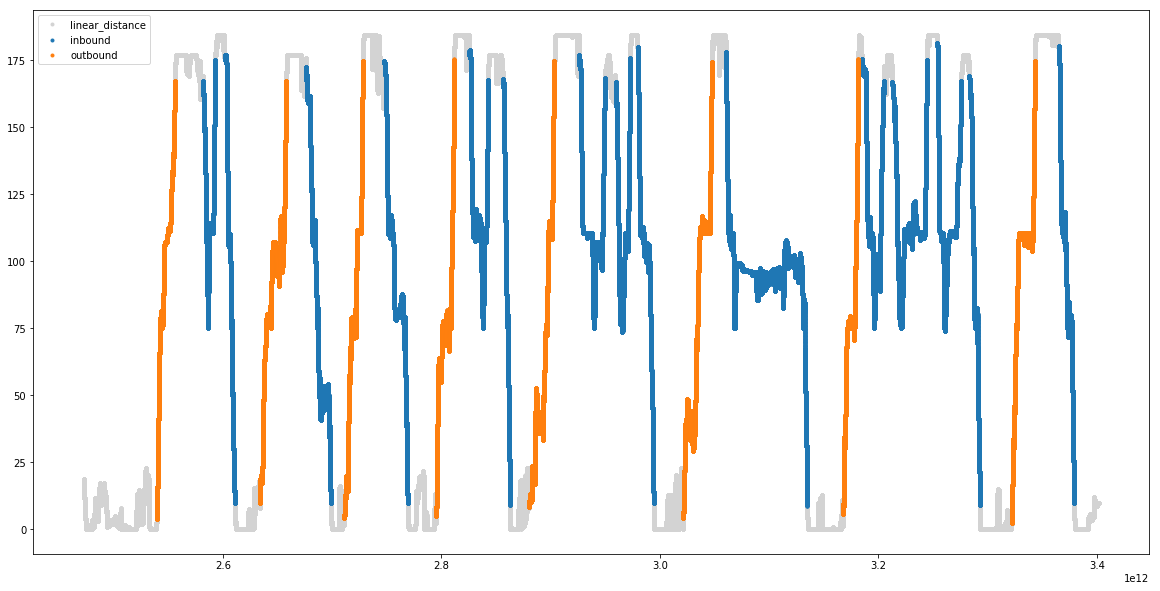

In [141]:
epoch_key = ('fra', 2, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

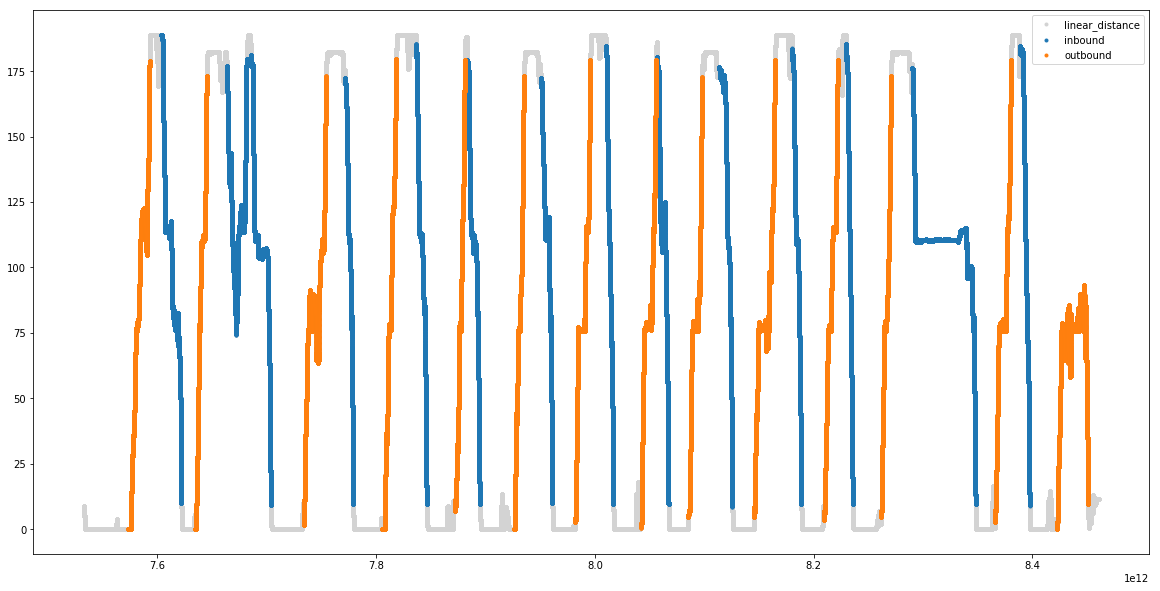

In [142]:
epoch_key = ('fra', 2, 6)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

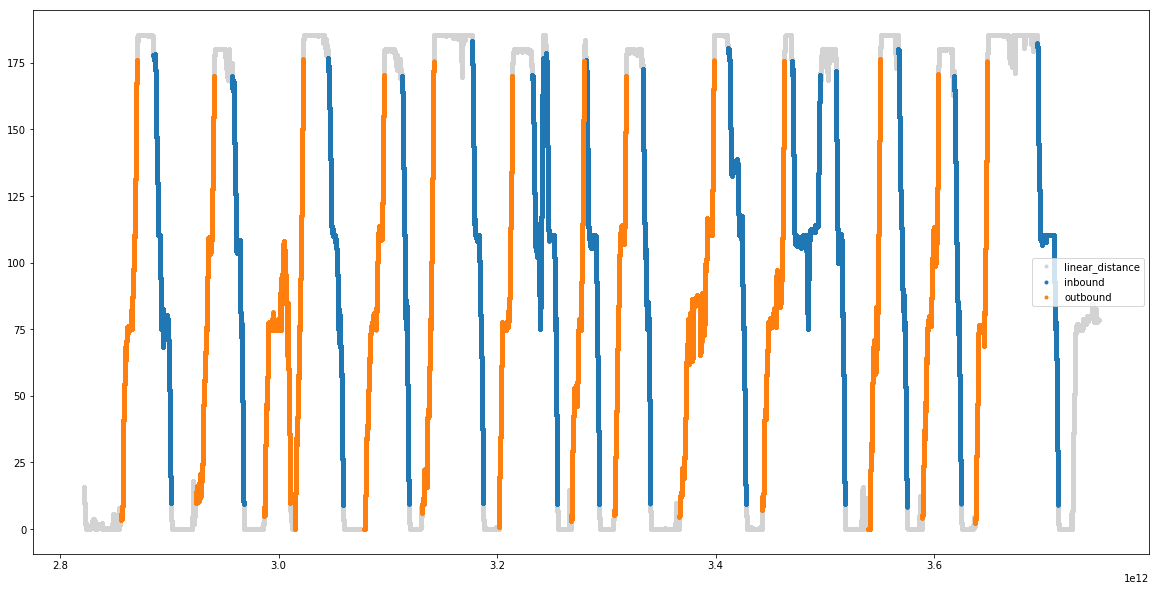

In [143]:
epoch_key = ('fra', 3, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

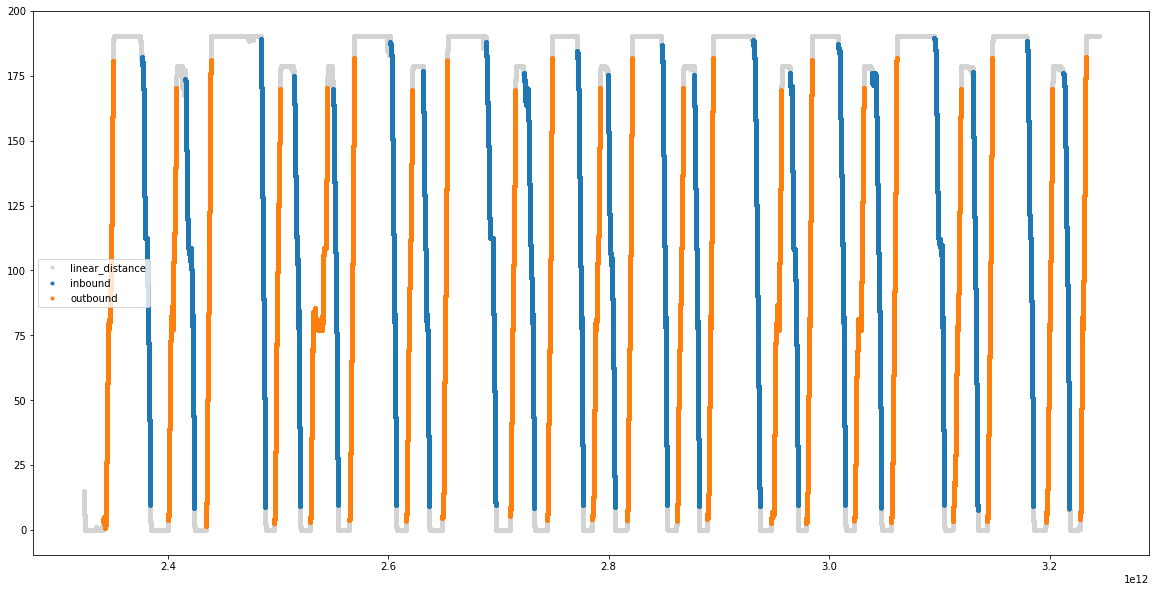

In [144]:
epoch_key = ('fra', 10, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [84]:
epoch_info.xs('bon').dropna()

environment type  exposure
day epoch                           
3   2          TrackB  run       1.0
    4          TrackB  run       2.0
    6          TrackA  run       1.0
4   2          TrackB  run       3.0
    4          TrackB  run       4.0
    6          TrackA  run       2.0
5   2          TrackB  run       5.0
    4          TrackB  run       6.0
    6          TrackA  run       3.0
6   2          TrackB  run       7.0
    4          TrackB  run       8.0
    6          TrackA  run       4.0
7   2          TrackB  run       9.0
    4          TrackB  run      10.0
    6          TrackA  run       5.0
8   2          TrackB  run      11.0
    4          TrackB  run      12.0
    6          TrackA  run       6.0
9   2          TrackB  run      13.0
    4          TrackB  run      14.0
    6          TrackA  run       7.0
10  2          TrackB  run      15.0
    4          TrackB  run      16.0
    6          TrackA  run       8.0

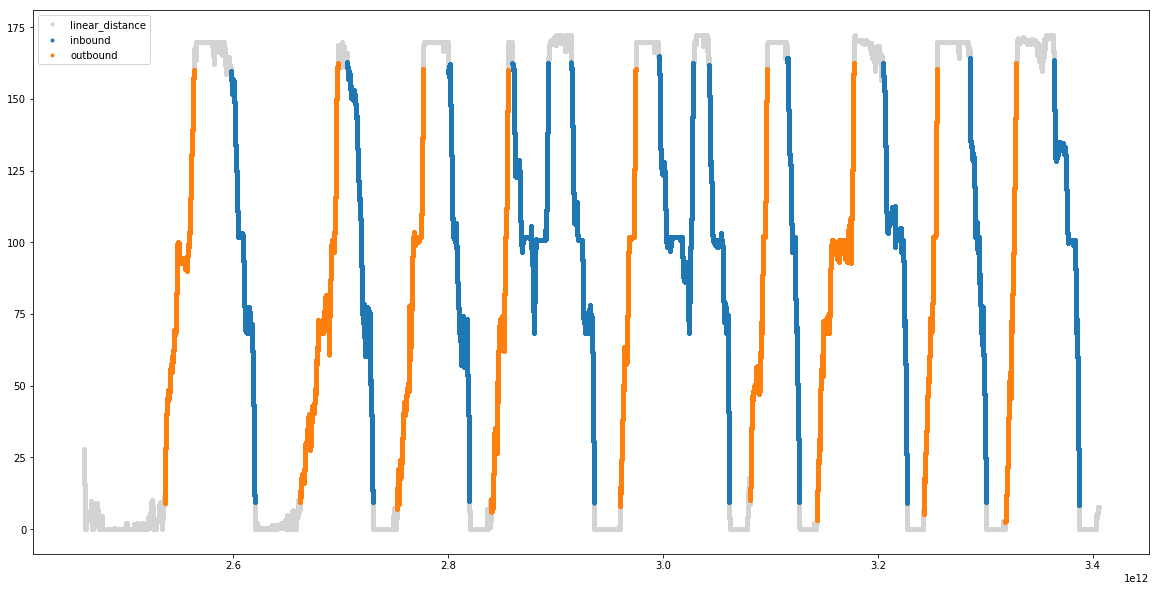

In [145]:
epoch_key = ('bon', 4, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

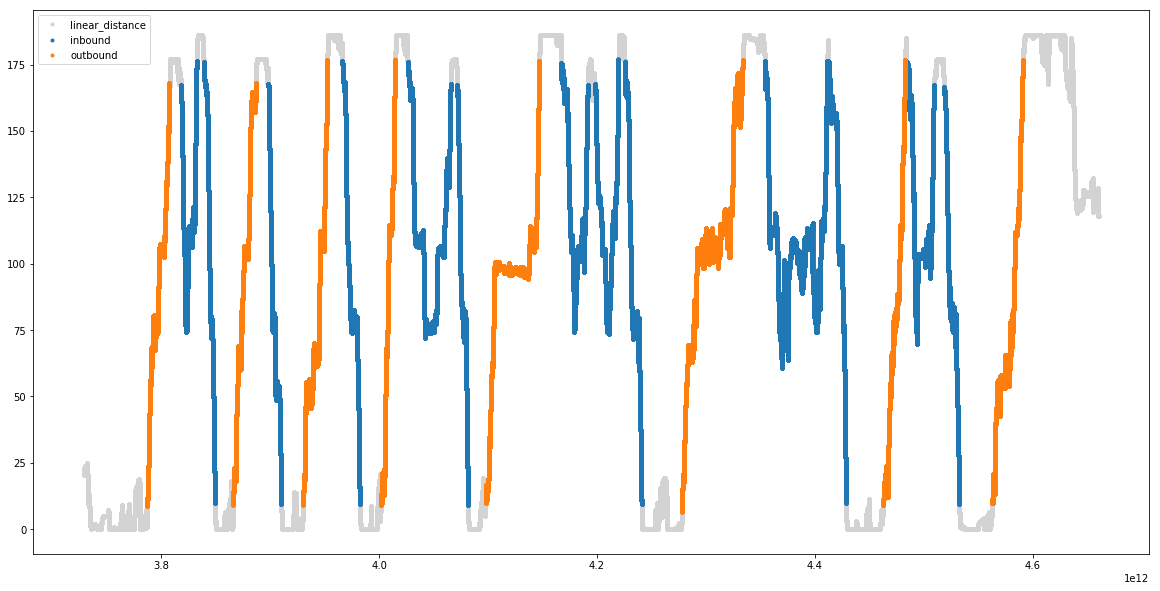

In [150]:
epoch_key = ('bon', 3, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

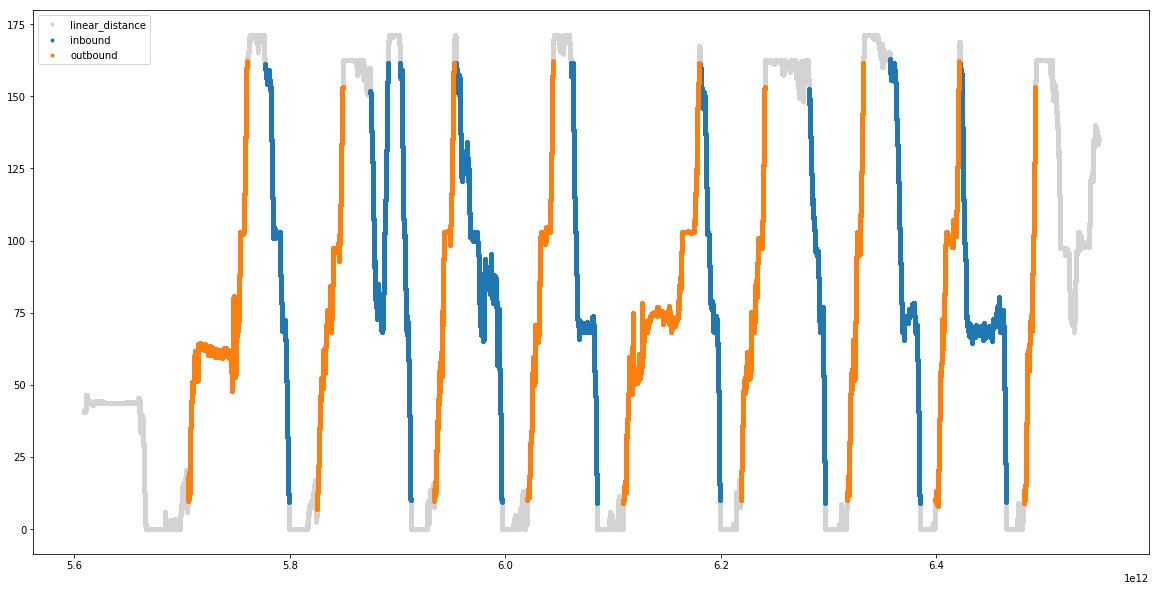

In [151]:
epoch_key = ('bon', 3, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

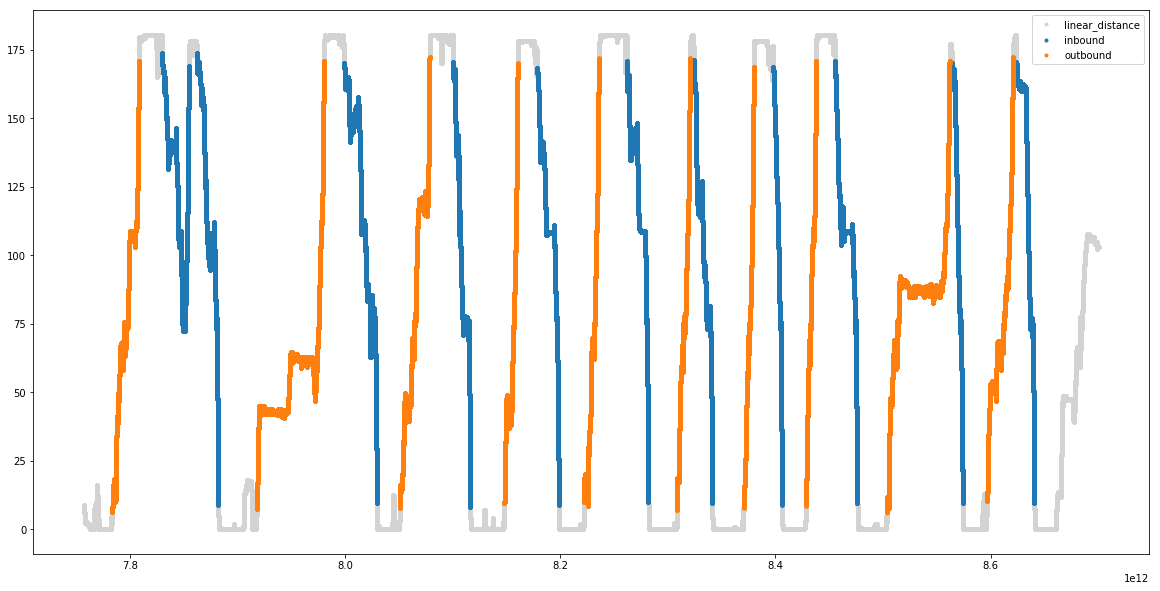

In [152]:
epoch_key = ('bon', 3, 6)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

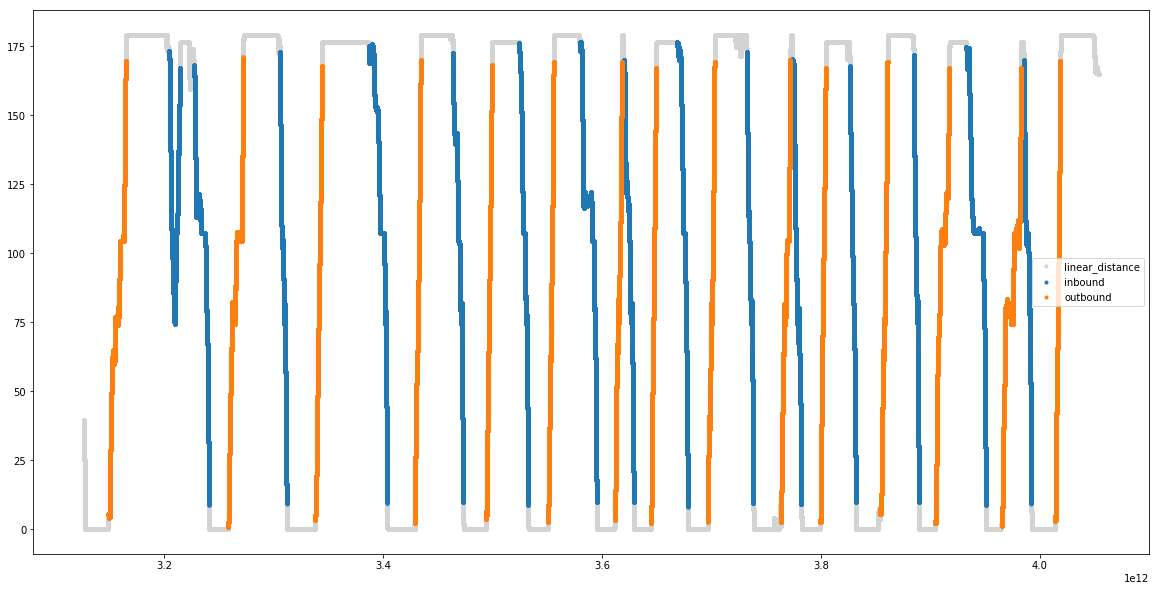

In [153]:
epoch_key = ('bon', 10, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [82]:
epoch_info.xs('Cor').dropna()

environment type  exposure
day epoch                           
1   2          TrackA  run       1.0
    4          TrackA  run       2.0
2   2          TrackA  run       3.0
    4          TrackA  run       4.0
3   2          TrackA  run       5.0
    4          TrackA  run       6.0
4   2          TrackA  run       7.0
    4          TrackB  run       1.0
    6          TrackB  run       2.0
5   2          TrackA  run       8.0
    4          TrackB  run       3.0
    6          TrackB  run       4.0
6   2          TrackA  run       9.0
    4          TrackB  run       5.0
    6          TrackB  run       6.0
7   2          TrackA  run      10.0
    4          TrackB  run       7.0
    6          TrackB  run       8.0
8   2          TrackA  run      11.0
    4          TrackB  run       9.0
    6          TrackB  run      10.0
9   2          TrackA  run      12.0
    4          TrackB  run      11.0
    6          TrackB  run      12.0

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


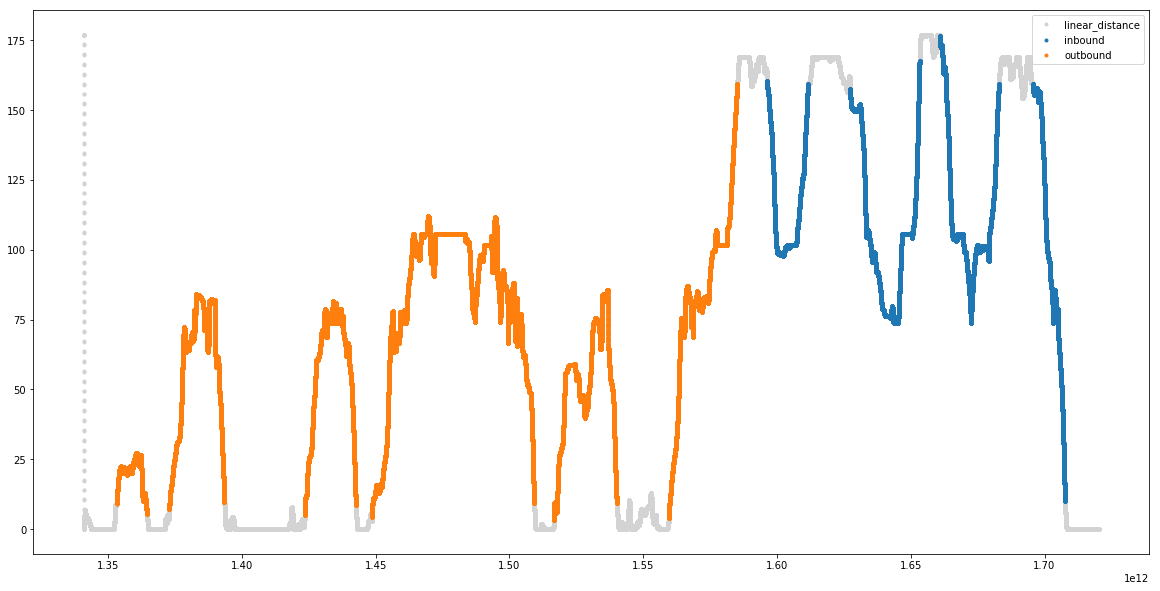

In [146]:
epoch_key = ('Cor', 1, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

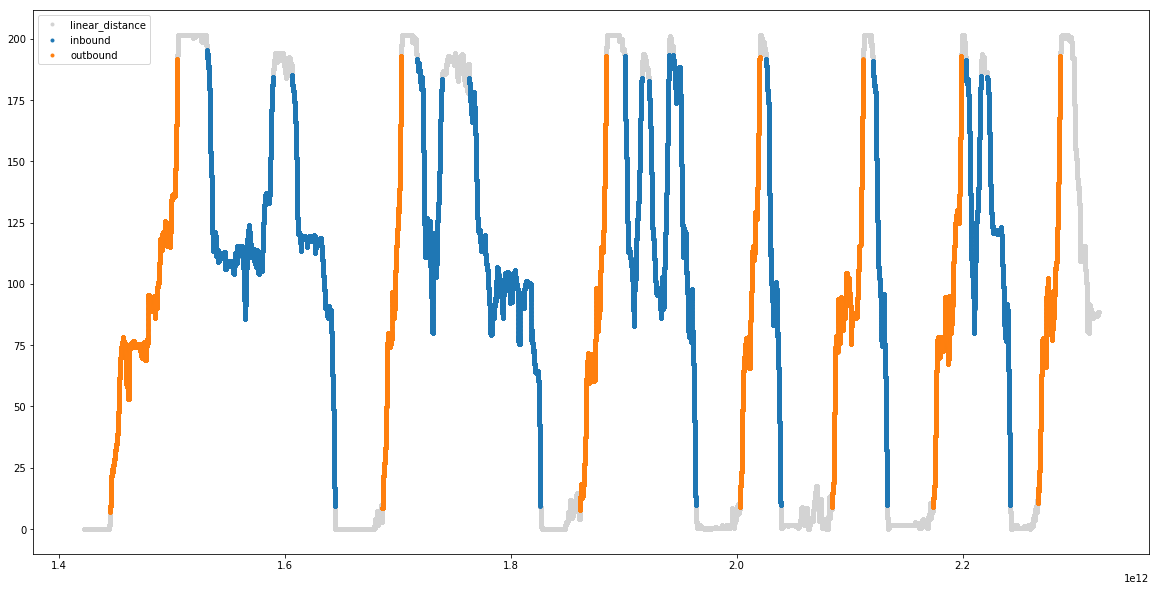

In [147]:
epoch_key = ('Cor', 2, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

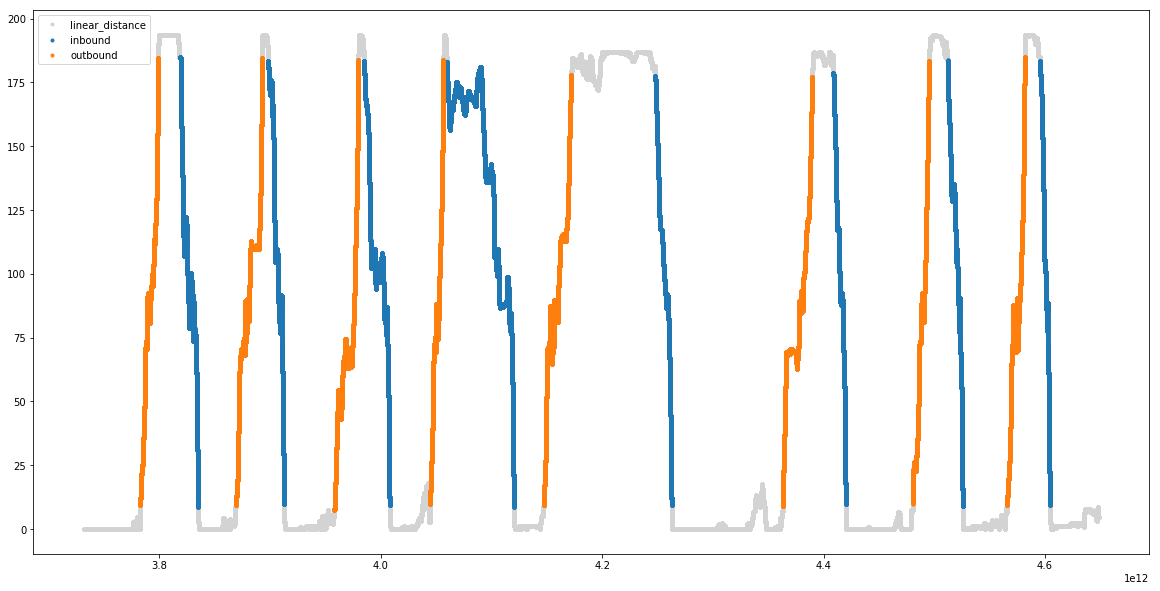

In [148]:
epoch_key = ('Cor', 2, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [154]:
epoch_info.xs('HPa').dropna()

environment type  exposure
day epoch                           
1   2             lin  run       1.0
    4            wtr1  run       1.0
    6            wtr1  run       2.0
2   2            wtr1  run       3.0
    4            wtr1  run       4.0
3   2            wtr1  run       5.0
    4            wtr1  run       6.0
4   2            wtr1  run       7.0
    4            wtr1  run       8.0
5   2            wtr1  run       9.0
    4            wtr1  run      10.0
6   2            wtr1  run      11.0
    4            wtr2  run       1.0
7   2            wtr1  run      12.0
    4            wtr2  run       2.0
8   2            wtr1  run      13.0
    4            wtr2  run       3.0

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


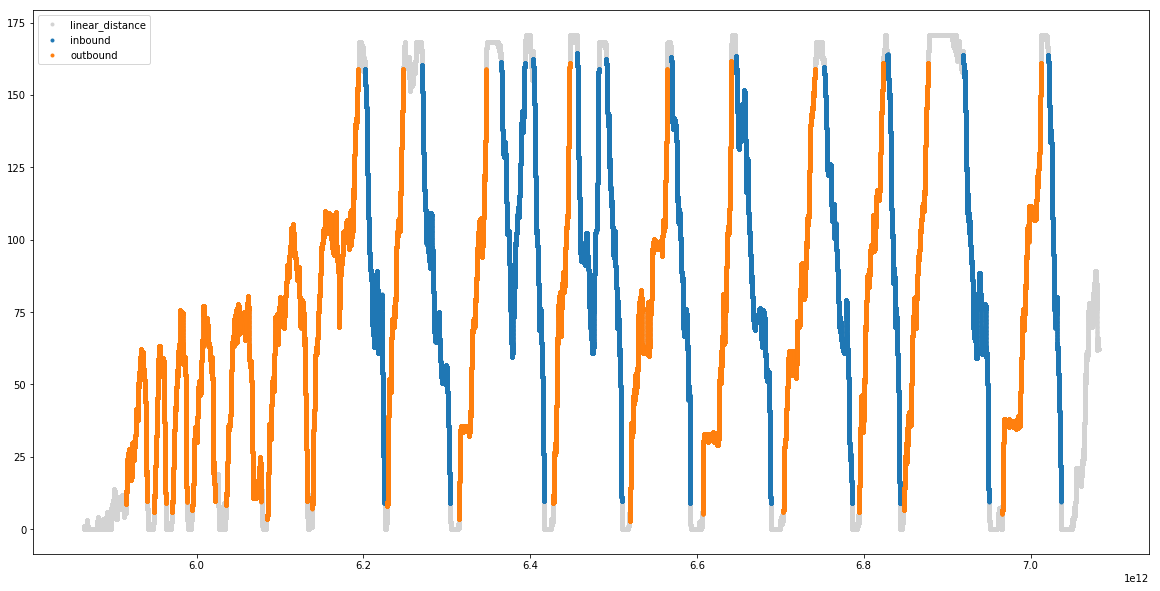

In [156]:
epoch_key = ('HPa', 1, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


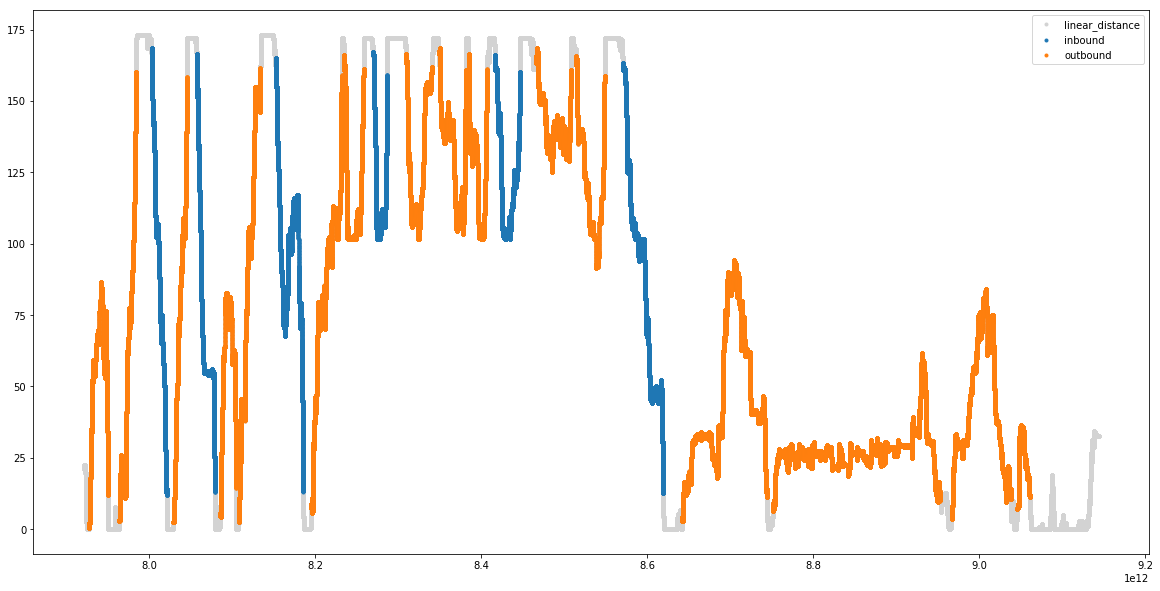

In [157]:
epoch_key = ('HPa', 1, 6)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


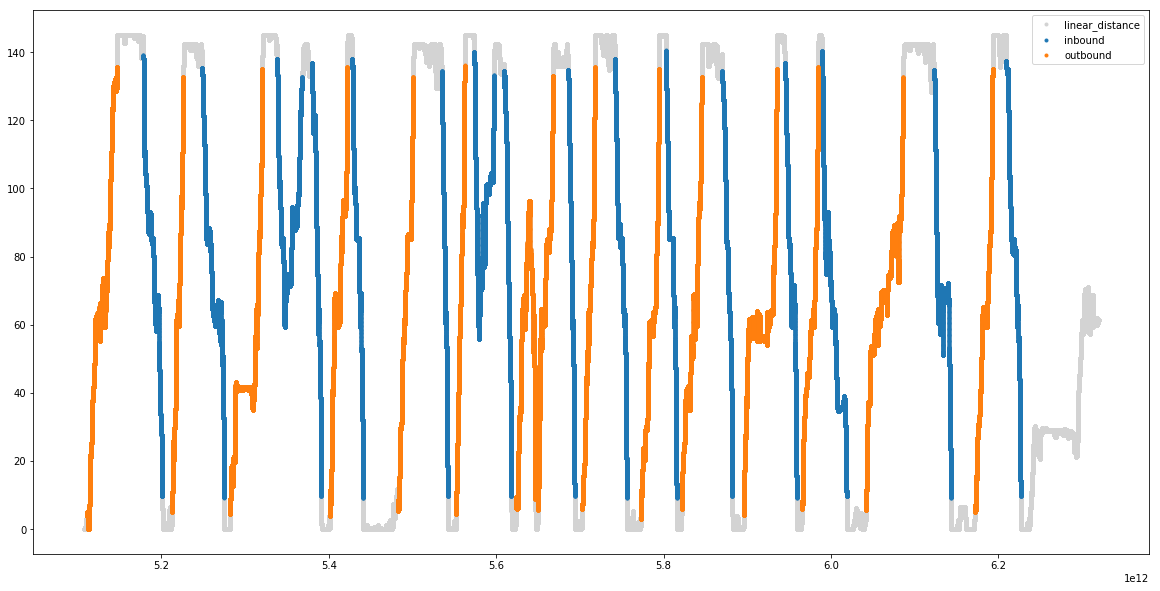

In [158]:
epoch_key = ('HPa', 2, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


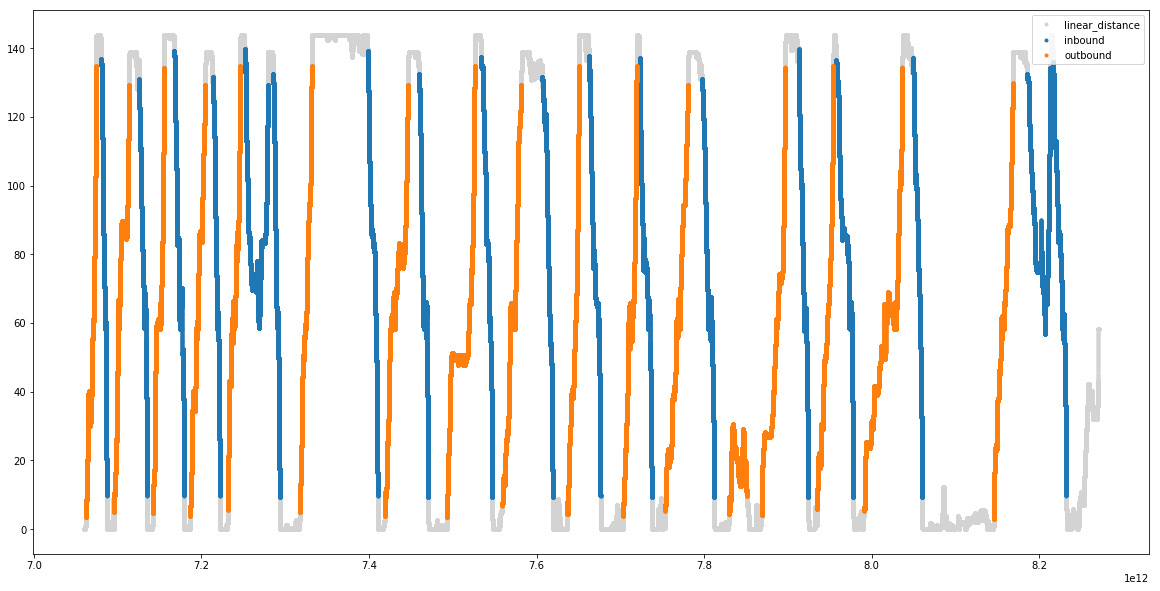

In [159]:
epoch_key = ('HPa', 2, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


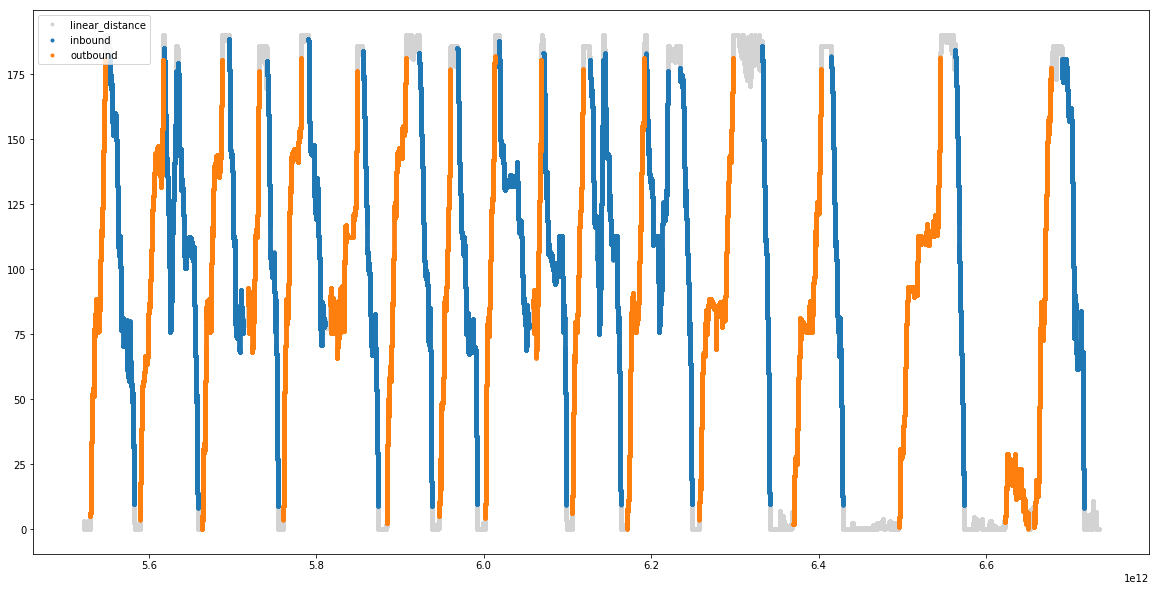

In [160]:
epoch_key = ('HPa', 7, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [161]:
epoch_info.xs('HPa').dropna()

environment type  exposure
day epoch                           
1   2             lin  run       1.0
    4            wtr1  run       1.0
    6            wtr1  run       2.0
2   2            wtr1  run       3.0
    4            wtr1  run       4.0
3   2            wtr1  run       5.0
    4            wtr1  run       6.0
4   2            wtr1  run       7.0
    4            wtr1  run       8.0
5   2            wtr1  run       9.0
    4            wtr1  run      10.0
6   2            wtr1  run      11.0
    4            wtr2  run       1.0
7   2            wtr1  run      12.0
    4            wtr2  run       2.0
8   2            wtr1  run      13.0
    4            wtr2  run       3.0

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


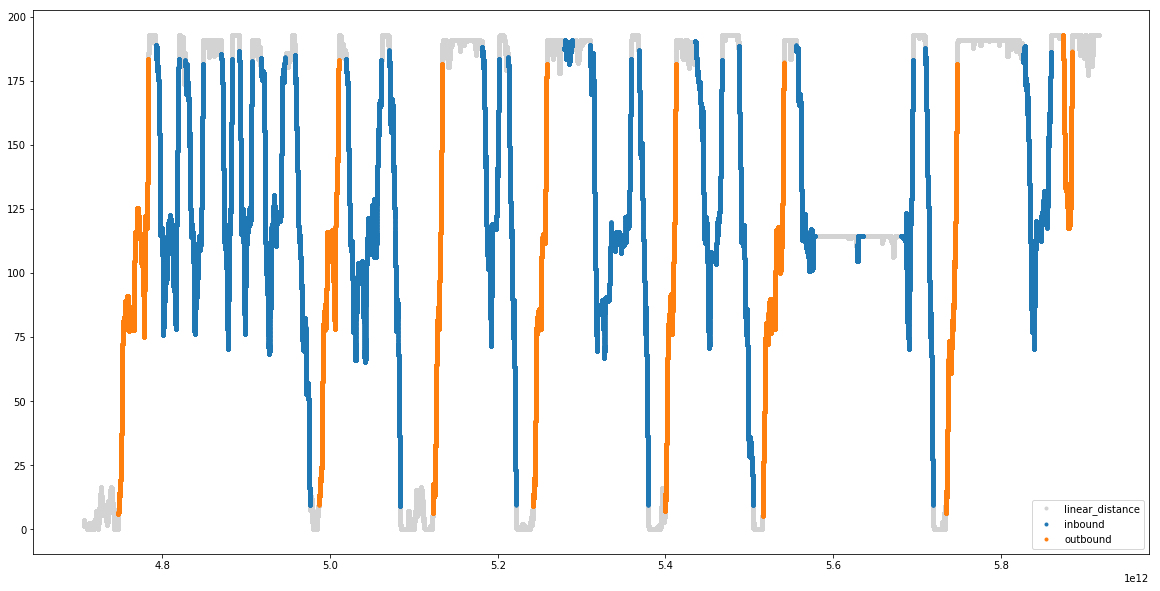

In [163]:
epoch_key = ('HPb', 1, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


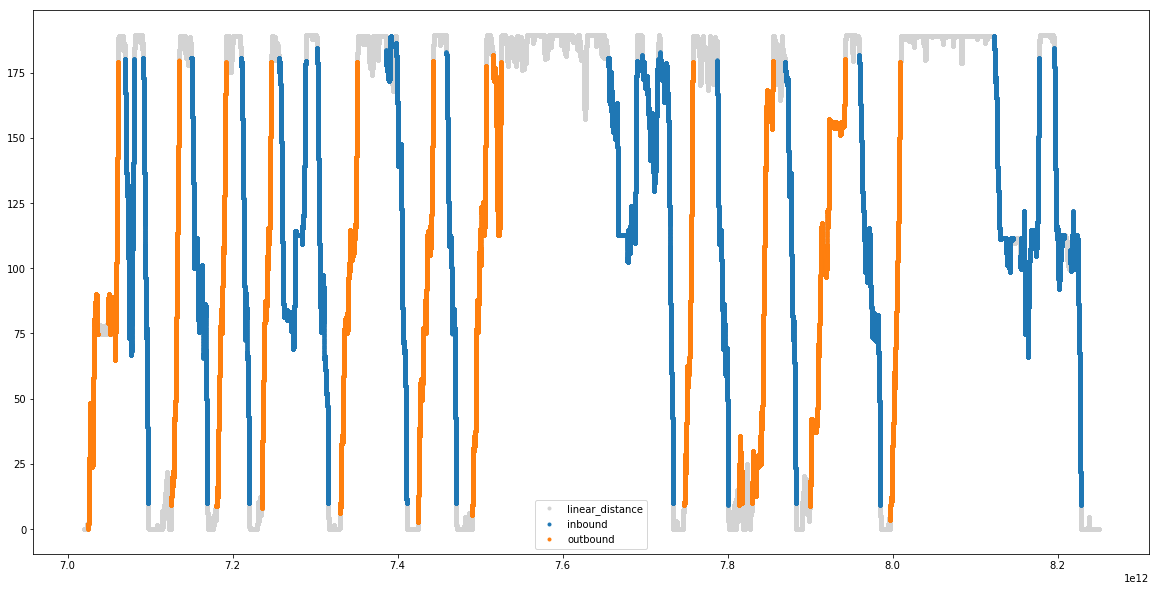

In [164]:
epoch_key = ('HPb', 1, 6)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


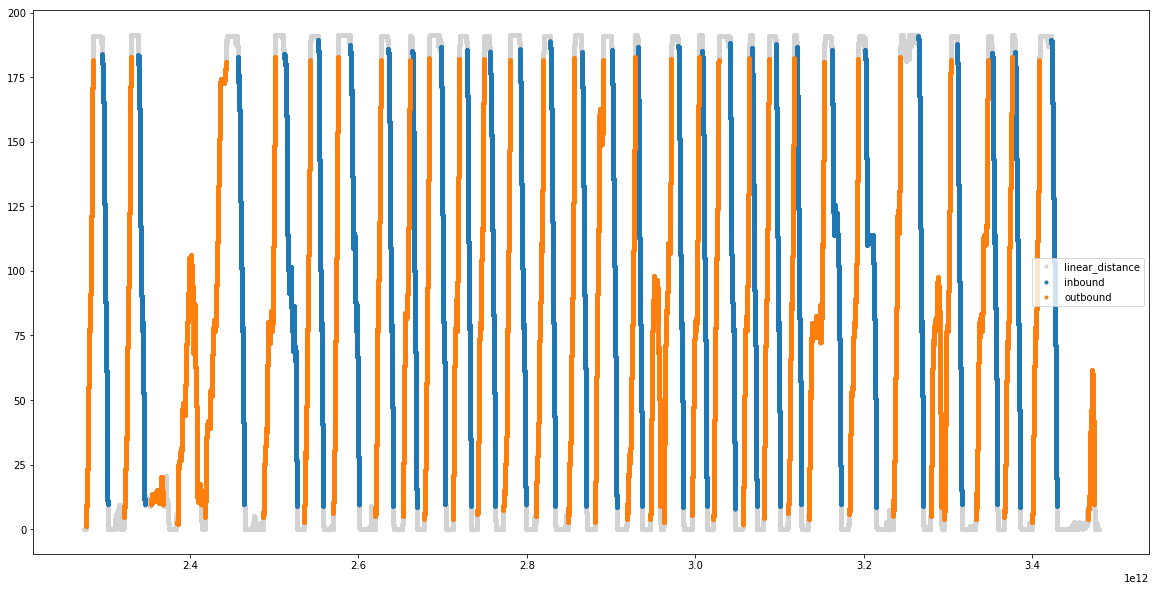

In [165]:
epoch_key = ('HPb', 8, 2)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [166]:
epoch_info.xs('HPc').dropna()

environment type  exposure
day epoch                           
1   2             lin  run       1.0
    4            wtr1  run       1.0
    6            wtr1  run       2.0
2   2            wtr1  run       3.0
    4            wtr1  run       4.0
3   2            wtr1  run       5.0
    4            wtr1  run       6.0
4   2            wtr1  run       7.0
    4            wtr1  run       8.0
5   2            wtr1  run       9.0
    4            wtr1  run      10.0
6   2            wtr1  run      11.0
    4            wtr2  run       1.0
7   2            wtr1  run      12.0
    4            wtr2  run       2.0
8   2            wtr1  run      13.0
    4            wtr2  run       3.0

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


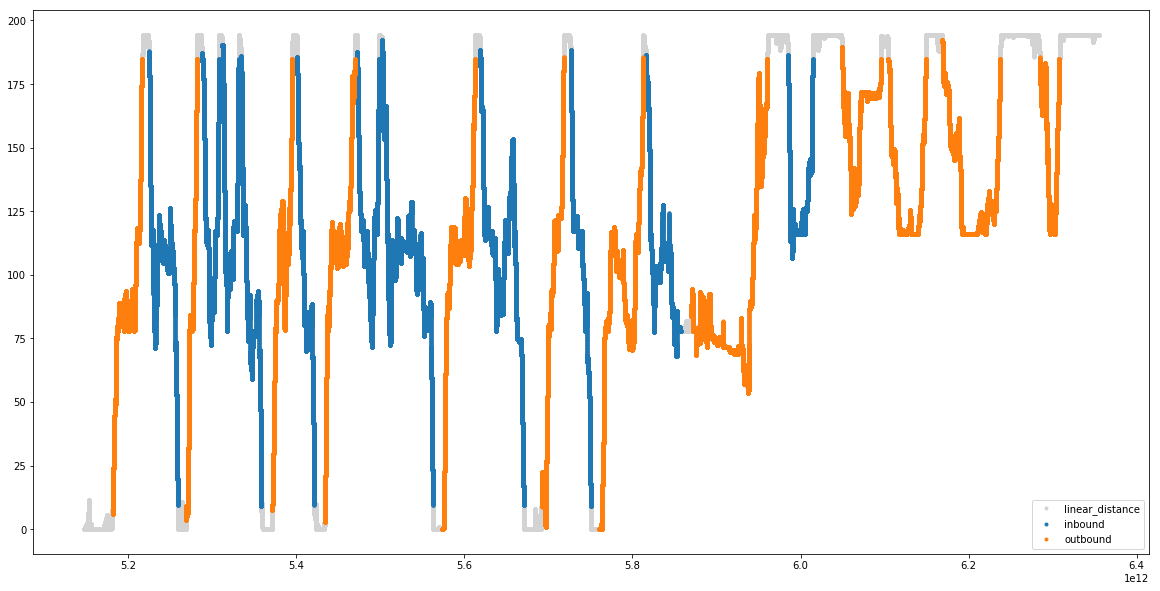

In [167]:
epoch_key = ('HPc', 1, 4)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


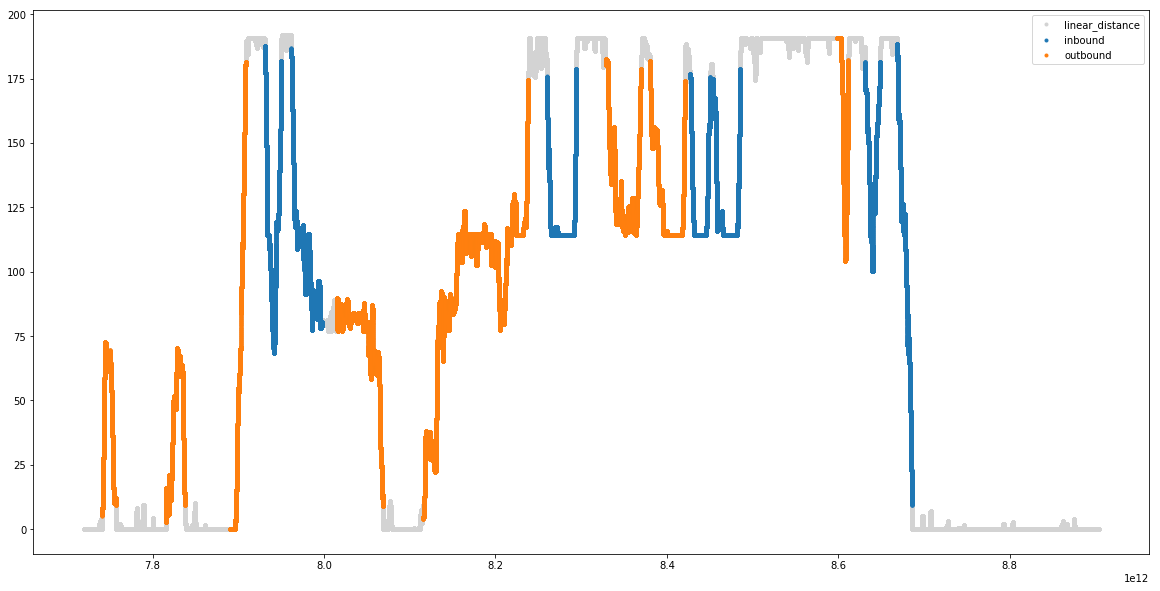

In [168]:
epoch_key = ('HPc', 1, 6)

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
plt.figure(figsize=(20, 10))
plt.plot(position_info.index, position_info.linear_distance,
         color='lightgrey', linestyle='None', marker='.')
plt.plot(position_info.loc[position_info.task == 'inbound'].index,
         position_info.loc[position_info.task == 'inbound'].linear_distance,
         linestyle='None', marker='.', label='inbound')
plt.plot(position_info.loc[position_info.task == 'outbound'].index,
         position_info.loc[position_info.task == 'outbound'].linear_distance,
         linestyle='None', marker='.', label='outbound');
plt.legend();

In [232]:
def circle(x, y, radius=0.15, ax=None):
    from matplotlib.patches import Circle
    from matplotlib.patheffects import withStroke
    circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                    edgecolor='black', facecolor=(0, 0, 0, .0125),
                    path_effects=[withStroke(linewidth=5, foreground='w')])
    if ax is None:
        ax = plt.gca()
    ax.add_artist(circle)
    
def get_segments_df(epoch_key, ANIMALS, max_distance_from_well=10):
    position = (pd.concat(
        [get_linear_position_structure(epoch_key, ANIMALS),
         get_position_dataframe(epoch_key, ANIMALS)], axis=1)
         .drop('trajectory_category_ind', axis=1)
        )
    well_locations = get_well_locations(epoch_key, ANIMALS)
    xy = np.stack((position.x_position, position.y_position), axis=1)
    segments_df, labeled_segments = segment_path(
        position.index, xy, well_locations,
        max_distance_from_well=max_distance_from_well)
    return score_inbound_outbound(segments_df).loc[
        :, ['from_well', 'to_well', 'task', 'is_correct']]
    

def plot_segment(epoch_key, segment, ANIMALS, max_distance_from_well=10):
    
    position = (pd.concat(
        [get_linear_position_structure(epoch_key, ANIMALS),
         get_position_dataframe(epoch_key, ANIMALS)], axis=1)
         .drop('trajectory_category_ind', axis=1)
    )
    well_locations = get_well_locations(epoch_key, ANIMALS)
    xy = np.stack((position.x_position, position.y_position), axis=1)
    segments_df, labeled_segments = segment_path(
        position.index, xy, well_locations,
        max_distance_from_well=max_distance_from_well)
    segments_df = score_inbound_outbound(segments_df).loc[
        :, ['from_well', 'to_well', 'task', 'is_correct']]

    plt.figure(figsize=(10, 10))
    plt.plot(position.x_position, position.y_position, color='lightgrey')
    plt.text(well_locations[0, 0], well_locations[0, 1], 'center', ha='center', va='center')
    plt.text(well_locations[1, 0], well_locations[1, 1], 'left', ha='center', va='center')
    plt.text(well_locations[2, 0], well_locations[2, 1], 'right', ha='center', va='center')
    
    for well in well_locations:
        circle(well[0], well[1], radius=max_distance_from_well)

    is_seg = labeled_segments.labeled_segments.isin([segment])
    plt.plot(position.x_position[is_seg], position.y_position[is_seg], linewidth=4)


    plt.figure(figsize=(15, 5))
    plt.plot(position.index, position.linear_distance, color='lightgrey')
    plt.plot(position.loc[is_seg].index, position.loc[is_seg].linear_distance, linewidth=4)

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


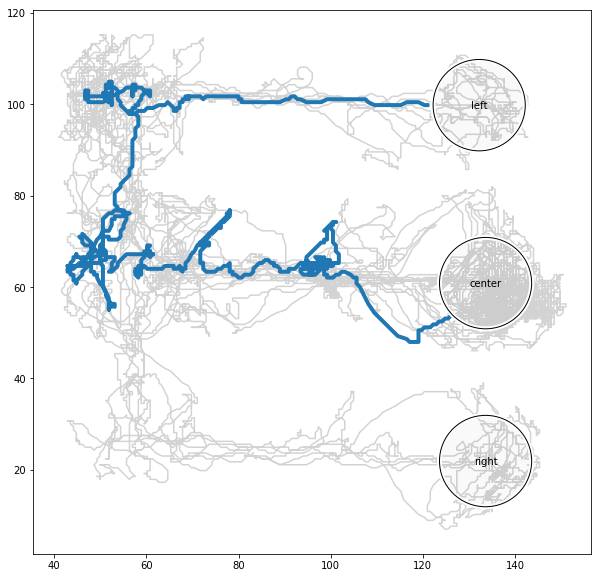

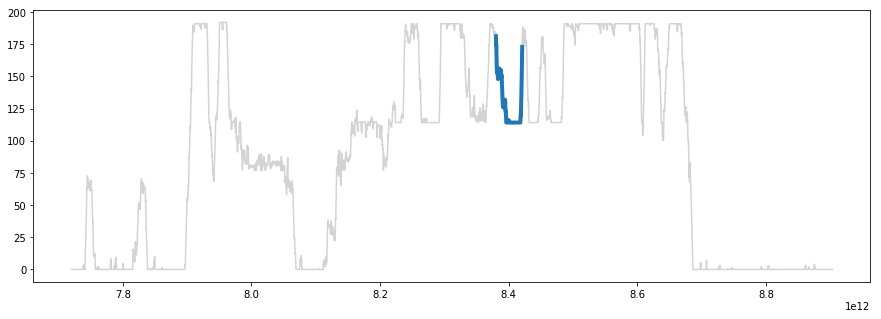

In [229]:
plot_segment(epoch_key, 73, ANIMALS)

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


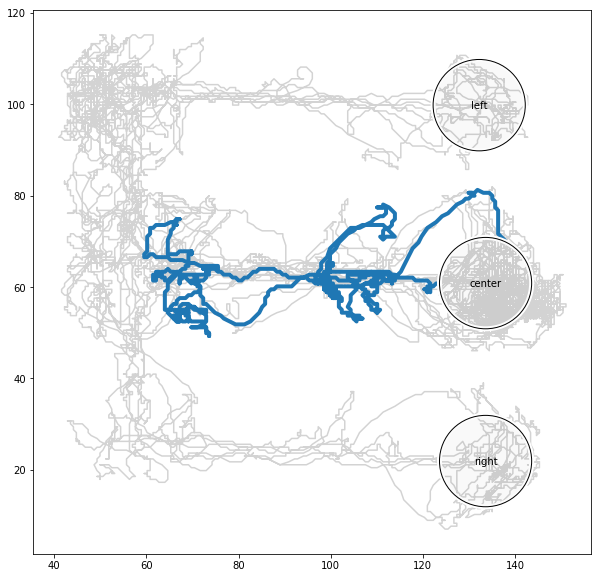

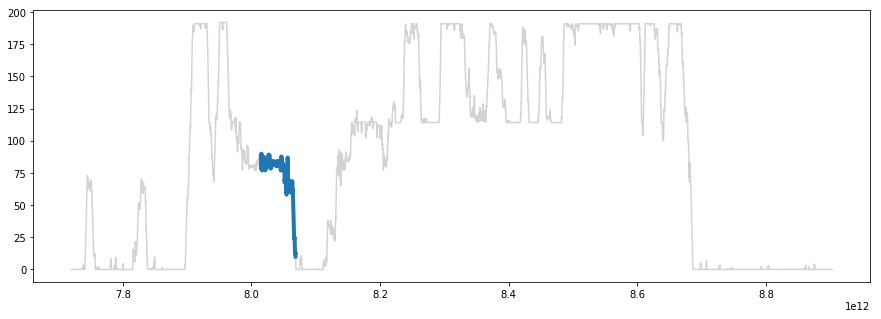

In [233]:
plot_segment(epoch_key, 52, ANIMALS)

/projectnb/braincom/edeno/conda_envs/Categorize_Replay_2017/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in less


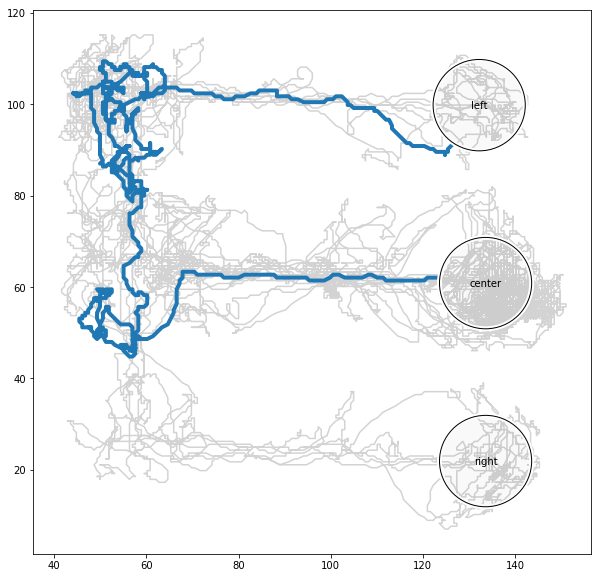

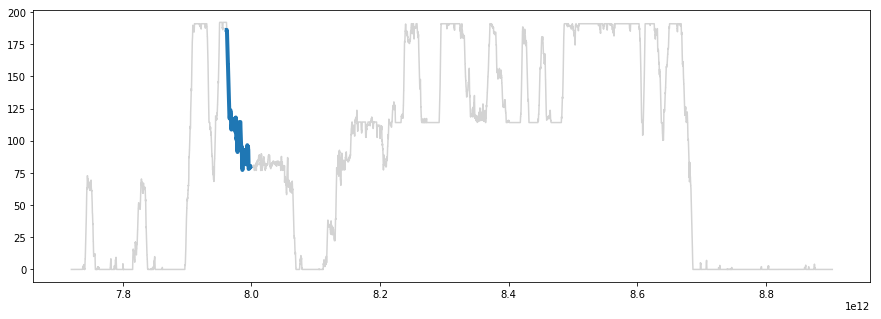

In [234]:
plot_segment(epoch_key, 46, ANIMALS)